<a href="https://colab.research.google.com/github/AakritiGuragain/Assignment-py/blob/main/chatbot_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Chatbot Systems: From Simple to Intelligent

This notebook demonstrates three progressively sophisticated approaches to building chatbots:

1. **Exact Matching** - Simple keyword/phrase lookup
2. **Pattern Matching** - Regular expressions and fuzzy matching
3. **Machine Learning** - Intent classification using NLP

By the end, you'll understand the tradeoffs between simplicity and intelligence in chatbot design.

---
## Setup and Installation

First, let's install the required libraries.

In [ ]:
!pip install -q scikit-learn nltk fuzzywuzzy python-Levenshtein

In [ ]:
import re
import random
import nltk
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("Setup complete!")

def interactive_chat(bot, bot_name="Bot"):
    """Simple interactive chat loop"""
    print(f"\n=== Chat with {bot_name} ===")
    print("Type 'quit' to exit\n")

    while True:
        try:
            user_input = input("You: ")
            if user_input.lower() in ['quit', 'exit', 'q']:
                print(f"{bot_name}: Goodbye!")
                break
            response = bot.get_response(user_input)
            print(f"{bot_name}: {response}\n")
        except KeyboardInterrupt:
            print(f"\n{bot_name}: Goodbye!")
            break

Setup complete!


---
## Method 1: Exact Matching Chatbot

The simplest approach uses a dictionary to map exact user inputs to predefined responses. This method is fast and predictable but extremely rigid.

### How It Works
- User input is converted to lowercase and stripped of whitespace
- The system looks for an exact match in a response dictionary
- If found, returns the corresponding response; otherwise, returns a default message

In [ ]:
class ExactMatchChatbot:
    """
    A chatbot that responds only to exact phrase matches.
    Simple, fast, but limited in flexibility.
    """

    def __init__(self):
        # Dictionary mapping exact inputs to responses
        self.responses = {
            "hello": "Hello! How can I help you today?",
            "hi": "Hi there! What can I do for you?",
            "how are you": "I'm doing great, thank you for asking!",
            "what is your name": "I'm ExactBot, a simple matching chatbot.",
            "bye": "Goodbye! Have a great day!",
            "goodbye": "See you later! Take care!",
            "thank you": "You're welcome!",
            "thanks": "Happy to help!",
            "help": "I can answer basic greetings. Try: hello, how are you, bye",
            "what time is it": "I don't have access to the current time, sorry!",
            "tell me a joke": "Why don't scientists trust atoms? Because they make up everything!",
        }
        self.default_response = "I don't understand that. Try typing 'help' for options."

    def preprocess(self, text):
        """Normalize input: lowercase and strip whitespace"""
        return text.lower().strip()

    def get_response(self, user_input):
        """Look up exact match in dictionary"""
        processed = self.preprocess(user_input)
        return self.responses.get(processed, self.default_response)

    def add_response(self, trigger, response):
        """Add a new trigger-response pair"""
        self.responses[trigger.lower().strip()] = response


# Create and test the chatbot
exact_bot = ExactMatchChatbot()

print("=== Exact Match Chatbot Demo ===")
print()

test_inputs = [
    "Hello",           # Should match
    "HELLO",           # Should match (case insensitive)
    "hello!",          # Won't match (punctuation)
    "Hi there",        # Won't match (extra words)
    "how are you",     # Should match
    "How are you doing?",  # Won't match
    "tell me a joke",  # Should match
]

for inp in test_inputs:
    response = exact_bot.get_response(inp)
    print(f"User: {inp}")
    print(f"Bot:  {response}")
    print()

=== Exact Match Chatbot Demo ===

User: Hello
Bot:  Hello! How can I help you today?

User: HELLO
Bot:  Hello! How can I help you today?

User: hello!
Bot:  I don't understand that. Try typing 'help' for options.

User: Hi there
Bot:  I don't understand that. Try typing 'help' for options.

User: how are you
Bot:  I'm doing great, thank you for asking!

User: How are you doing?
Bot:  I don't understand that. Try typing 'help' for options.

User: tell me a joke
Bot:  Why don't scientists trust atoms? Because they make up everything!



### Limitations of Exact Matching

As you can see above, exact matching fails when:
- Users add punctuation ("hello!")
- Users phrase things slightly differently ("Hi there" vs "Hi")
- Users ask the same thing in different ways

This leads us to pattern matching...

---
## Method 2: Pattern Matching Chatbot

Pattern matching uses regular expressions and fuzzy string matching to handle variations in user input. This approach is more flexible while still being rule-based.

### Techniques Used
1. **Regular Expressions** - Match patterns like "my name is [X]"
2. **Fuzzy Matching** - Handle typos and similar phrases
3. **Keyword Detection** - Respond based on presence of keywords

In [ ]:
class PatternMatchChatbot:
    """
    A chatbot using regex patterns and fuzzy matching.
    More flexible than exact matching, handles variations better.
    """

    def __init__(self):
        # Regex patterns with capture groups
        self.patterns = [
            # Greetings
            (r"\b(hi|hello|hey|greetings)\b", self._greet),

            # Name extraction
            (r"my name is (\w+)", self._remember_name),
            (r"i am (\w+)", self._remember_name),
            (r"call me (\w+)", self._remember_name),

            # Questions about the bot
            (r"what('s| is) your name", self._bot_name),
            (r"who are you", self._bot_name),

            # Feelings/state questions
            (r"how are you( doing)?", self._how_are_you),
            (r"how('s| is) it going", self._how_are_you),

            # Help requests
            (r"\b(help|assist|support)\b", self._help),
            (r"what can you do", self._help),

            # Math operations
            (r"(\d+)\s*[+]\s*(\d+)", self._add),
            (r"(\d+)\s*[-]\s*(\d+)", self._subtract),
            (r"(\d+)\s*[*x]\s*(\d+)", self._multiply),

            # Farewells
            (r"\b(bye|goodbye|see you|later)\b", self._farewell),

            # Thanks
            (r"\b(thanks|thank you|thx)\b", self._thanks),

            # Email extraction
            (r"\b([\w\.-]+@[\w\.-]+\.\w+)\b", self._extract_email),

            # Date extraction (YYYY-MM-DD or DD/MM/YYYY)
            (r"\b(\d{4}-\d{2}-\d{2}|\d{1,2}/\d{1,2}/\d{4})\b", self._extract_date),

        ]

        # Fuzzy matching fallbacks (phrase, response, threshold)
        self.fuzzy_responses = [
            ("tell me a joke", "Why do programmers prefer dark mode? Because light attracts bugs!", 70),
            ("what is the weather", "I can't check the weather, but I hope it's nice where you are!", 65),
            ("what time is it", "I don't have access to the current time.", 70),
        ]

        self.user_name = None
        self.default_response = "I'm not sure I understand. Could you rephrase that?"

    def preprocess(self, text):
        """Clean and normalize input"""
        text = text.lower().strip()
        # The previous line `text = re.sub(r'[\w\s+\-*]', '', text)` was incorrect
        # as it removed all alphanumeric characters, spaces, and math operators.
        # Removing this line to allow patterns to match meaningful input.
        return text

    # Response methods
    def _greet(self, match):
        greetings = ["Hello!", "Hi there!", "Hey! How can I help?"]
        if self.user_name:
            return f"Hello, {self.user_name}! Nice to see you again."
        return random.choice(greetings)

    def _remember_name(self, match):
        self.user_name = match.group(1).capitalize()
        return f"Nice to meet you, {self.user_name}! I'll remember that."

    def _bot_name(self, match):
        return "I'm PatternBot, a regex-powered chatbot!"

    def _how_are_you(self, match):
        responses = [
            "I'm doing great, thanks for asking!",
            "Running smoothly! How about you?",
            "All systems operational! 😊"
        ]
        return random.choice(responses)

    def _help(self, match):
        return """I can help with:
• Greetings (hi, hello, hey)
• Remember your name (say 'my name is [name]')
• Basic math (try '5 + 3' or '10 * 2')
• Small talk and jokes"""

    def _add(self, match):
        a, b = int(match.group(1)), int(match.group(2))
        return f"{a} + {b} = {a + b}"

    def _subtract(self, match):
        a, b = int(match.group(1)), int(match.group(2))
        return f"{a} - {b} = {a - b}"

    def _multiply(self, match):
        a, b = int(match.group(1)), int(match.group(2))
        return f"{a} × {b} = {a * b}"

    def _farewell(self, match):
        if self.user_name:
            return f"Goodbye, {self.user_name}! Take care!"
        return "Goodbye! Have a great day!"

    def _thanks(self, match):
        return random.choice(["You're welcome!", "Happy to help!", "Anytime!"])

    def get_response(self, user_input):
        """Try patterns first, then fuzzy matching, then default"""
        processed = self.preprocess(user_input)

        # Try regex patterns
        for pattern, handler in self.patterns:
            match = re.search(pattern, processed, re.IGNORECASE)
            if match:
                return handler(match)

        # Try fuzzy matching
        for phrase, response, threshold in self.fuzzy_responses:
            similarity = fuzz.ratio(processed, phrase)
            if similarity >= threshold:
                return response

        return self.default_response

    def _extract_email(self, match):
        email = match.group(1)
        return f"I detected this email address: {email}"

    def _extract_date(self, match):
        date = match.group(1)
        return f"I found this date: {date}"


# Create and test
pattern_bot = PatternMatchChatbot()

print("=== Pattern Match Chatbot Demo ===")
print()

test_inputs = [
    "Hey there!",
    "My name is Alice",
    "Hello",                    # Should remember name
    "What's your name?",
    "How are you doing?",
    "15 + 27",                  # Math
    "100 * 5",
    "tel me a jok",             # Fuzzy match (typo)
    "what is the wether like",  # Fuzzy match (typo)
    "Goodbye!",
]

for inp in test_inputs:
    response = pattern_bot.get_response(inp)
    print(f"User: {inp}")
    print(f"Bot:  {response}")
    print()

=== Pattern Match Chatbot Demo ===

User: Hey there!
Bot:  Hello!

User: My name is Alice
Bot:  Nice to meet you, Alice! I'll remember that.

User: Hello
Bot:  Hello, Alice! Nice to see you again.

User: What's your name?
Bot:  I'm PatternBot, a regex-powered chatbot!

User: How are you doing?
Bot:  I'm doing great, thanks for asking!

User: 15 + 27
Bot:  15 + 27 = 42

User: 100 * 5
Bot:  100 × 5 = 500

User: tel me a jok
Bot:  Why do programmers prefer dark mode? Because light attracts bugs!

User: what is the wether like
Bot:  I can't check the weather, but I hope it's nice where you are!

User: Goodbye!
Bot:  Goodbye, Alice! Take care!



### Advantages Over Exact Matching

Pattern matching handles:
- Variable information extraction ("my name is X")
- Typos via fuzzy matching
- Multiple phrasings of the same intent
- Dynamic responses (math calculations)

However, writing patterns for every possible way users might ask something becomes tedious. This is where ML shines...

---
## Method 3: Machine Learning Chatbot

Instead of manually writing patterns, we train a model to classify user **intents** from examples. The model learns to generalize from training data to handle inputs it has never seen.

### Architecture
1. **TF-IDF Vectorizer** - Converts text to numerical features
2. **Naive Bayes Classifier** - Predicts intent from features
3. **Response Templates** - Maps intents to appropriate responses

In [ ]:
# Training data: (text, intent) pairs
TRAINING_DATA = [
    # Greeting intent
    ("hello", "greeting"),
    ("hi", "greeting"),
    ("hey", "greeting"),
    ("good morning", "greeting"),
    ("good afternoon", "greeting"),
    ("good evening", "greeting"),
    ("hi there", "greeting"),
    ("hello there", "greeting"),
    ("greetings", "greeting"),
    ("whats up", "greeting"),
    ("howdy", "greeting"),
    ("hiya", "greeting"),

    # Farewell intent
    ("bye", "farewell"),
    ("goodbye", "farewell"),
    ("see you later", "farewell"),
    ("see you", "farewell"),
    ("take care", "farewell"),
    ("have a good day", "farewell"),
    ("catch you later", "farewell"),
    ("gotta go", "farewell"),
    ("im leaving", "farewell"),
    ("talk to you later", "farewell"),

    # Thanks intent
    ("thank you", "thanks"),
    ("thanks", "thanks"),
    ("thanks a lot", "thanks"),
    ("thank you so much", "thanks"),
    ("i appreciate it", "thanks"),
    ("much appreciated", "thanks"),
    ("thanks for your help", "thanks"),
    ("thx", "thanks"),
    ("ty", "thanks"),

    # Bot info intent
    ("what is your name", "bot_info"),
    ("who are you", "bot_info"),
    ("what are you", "bot_info"),
    ("tell me about yourself", "bot_info"),
    ("whats your name", "bot_info"),
    ("what should i call you", "bot_info"),
    ("are you a bot", "bot_info"),
    ("are you human", "bot_info"),
    ("are you real", "bot_info"),

    # Help intent
    ("help", "help"),
    ("help me", "help"),
    ("i need help", "help"),
    ("can you help me", "help"),
    ("what can you do", "help"),
    ("what do you do", "help"),
    ("how do you work", "help"),
    ("show me what you can do", "help"),
    ("assist me", "help"),
    ("i need assistance", "help"),

    # Wellness check intent
    ("how are you", "wellness"),
    ("how are you doing", "wellness"),
    ("hows it going", "wellness"),
    ("how do you feel", "wellness"),
    ("are you okay", "wellness"),
    ("you doing alright", "wellness"),
    ("whats up with you", "wellness"),
    ("how have you been", "wellness"),

    # Joke intent
    ("tell me a joke", "joke"),
    ("say something funny", "joke"),
    ("make me laugh", "joke"),
    ("do you know any jokes", "joke"),
    ("got any jokes", "joke"),
    ("i want to hear a joke", "joke"),
    ("tell a joke", "joke"),
    ("joke please", "joke"),

    # Weather intent
    ("what is the weather", "weather"),
    ("hows the weather", "weather"),
    ("whats the weather like", "weather"),
    ("is it raining", "weather"),
    ("is it sunny", "weather"),
    ("weather forecast", "weather"),
    ("will it rain today", "weather"),
    ("temperature outside", "weather"),

    # Time intent
    ("what time is it", "time"),
    ("whats the time", "time"),
    ("current time", "time"),
    ("what is the time now", "time"),
    ("do you know what time it is", "time"),
    ("tell me the time", "time"),

    # Complaint intent
    ("this is not working", "complaint"),
    ("im having a problem", "complaint"),
    ("something is broken", "complaint"),
    ("this is frustrating", "complaint"),
    ("im unhappy with this", "complaint"),
    ("there is an issue", "complaint"),
    ("im facing a bug", "complaint"),

    # Recommendation intent
    ("can you recommend something", "recommendation"),
    ("what do you suggest", "recommendation"),
    ("any recommendations", "recommendation"),
    ("what should i try", "recommendation"),
    ("can you suggest something for me", "recommendation"),
    ("recommend me something", "recommendation"),
    ("do you have any suggestions", "recommendation"),


]

print(f"Training data: {len(TRAINING_DATA)} examples")
print(f"Unique intents: {len(set(intent for _, intent in TRAINING_DATA))}")

Training data: 94 examples
Unique intents: 11


In [ ]:
class MLChatbot:
    """
    A chatbot using machine learning for intent classification.
    Uses TF-IDF features with Naive Bayes classifier.
    """

    def __init__(self, training_data, confidence_threshold=0.3):
        self.confidence_threshold = confidence_threshold

        # Response templates for each intent
        self.responses = {
            "greeting": [
                "Hello! How can I help you today?",
                "Hi there! What's on your mind?",
                "Hey! Great to see you!",
            ],
            "farewell": [
                "Goodbye! Have a wonderful day!",
                "See you later! Take care!",
                "Bye! Feel free to come back anytime!",
            ],
            "thanks": [
                "You're welcome!",
                "Happy to help!",
                "Anytime! Let me know if you need anything else.",
            ],
            "bot_info": [
                "I'm MLBot, a machine learning powered chatbot! I use NLP to understand your messages.",
                "I'm an AI assistant trained to classify intents and respond helpfully.",
            ],
            "help": [
                "I can help with greetings, jokes, general questions, and more! Just ask naturally.",
                "Try asking me things like 'tell me a joke' or 'how are you'. I understand natural language!",
            ],
            "wellness": [
                "I'm doing great, thank you for asking! How about you?",
                "All systems running smoothly! Thanks for checking in.",
                "I'm wonderful! Ready to help with whatever you need.",
            ],
            "joke": [
                "Why do programmers prefer dark mode? Because light attracts bugs!",
                "Why did the developer go broke? Because he used up all his cache!",
                "What's a computer's favorite snack? Microchips!",
                "Why do Java developers wear glasses? Because they don't C#!",
            ],
            "weather": [
                "I don't have access to live weather data, but I hope it's nice where you are!",
                "I can't check the weather currently. Try a weather app for accurate info!",
            ],
            "time": [
                "I don't have access to the current time, but your device should know!",
                "I can't tell time, but check the corner of your screen!",
            ],

            "complaint": [
                "I'm sorry to hear that. Please provide more details.",
                "I'm here to help. Let me know what's causing the issue.",
                "I'll work on that. Any additional information?",
            ],

          "recommendation": [
          "I’d be happy to recommend something! What are you interested in?",
          "Sure! Tell me a bit more about what you’re looking for.",
          "I can suggest ideas — just let me know your preferences.",
            ],


        }

        self.default_response = "I'm not quite sure what you mean. Could you try rephrasing?"

        # Build and train the model
        self._train(training_data)

    def _preprocess(self, text):
        """Clean text for classification"""
        text = text.lower().strip()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text

    def _train(self, training_data):
        """Train the intent classifier"""
        texts = [self._preprocess(text) for text, _ in training_data]
        intents = [intent for _, intent in training_data]

        # Create pipeline: TF-IDF -> Naive Bayes
        self.pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                ngram_range=(1, 2),  # Use unigrams and bigrams
                max_features=1000,
                stop_words='english'
            )),
            ('clf', MultinomialNB(alpha=0.1))
        ])

        self.pipeline.fit(texts, intents)
        self.classes = self.pipeline.classes_

        print(f"Model trained on {len(texts)} examples")
        print(f"Intent classes: {list(self.classes)}")

    def predict_intent(self, text):
        """Predict intent with confidence score"""
        processed = self._preprocess(text)
        probabilities = self.pipeline.predict_proba([processed])[0]

        max_idx = probabilities.argmax()
        intent = self.classes[max_idx]
        confidence = probabilities[max_idx]

        return intent, confidence, dict(zip(self.classes, probabilities))

    def get_response(self, user_input, verbose=False):
        """Get response based on predicted intent"""
        intent, confidence, all_probs = self.predict_intent(user_input)

        if verbose:
            print(f"  [Predicted: {intent}, Confidence: {confidence:.2f}]")

        if confidence < self.confidence_threshold:
            return self.default_response

        return random.choice(self.responses.get(intent, [self.default_response]))

    def evaluate(self, test_data):
        """Evaluate model on test data"""
        texts = [self._preprocess(text) for text, _ in test_data]
        true_intents = [intent for _, intent in test_data]

        predictions = self.pipeline.predict(texts)
        print(classification_report(true_intents, predictions))

# Train the ML chatbot first
ml_bot = MLChatbot(TRAINING_DATA, confidence_threshold=0.3)

class HybridChatbot:
    """
    Hybrid chatbot that uses pattern matching for structured queries
    and ML-based intent classification for everything else.
    """

    def __init__(self, pattern_bot, ml_bot):
        self.pattern_bot = pattern_bot
        self.ml_bot = ml_bot

    def get_response(self, user_input):
        # Try pattern matching first
        pattern_response = self.pattern_bot.get_response(user_input)

        if pattern_response != self.pattern_bot.default_response:
            return pattern_response

        # Fall back to ML chatbot
        return self.ml_bot.get_response(user_input)

hybrid_bot = HybridChatbot(pattern_bot, ml_bot)
interactive_chat(hybrid_bot, "HybridBot")

Model trained on 94 examples
Intent classes: [np.str_('bot_info'), np.str_('complaint'), np.str_('farewell'), np.str_('greeting'), np.str_('help'), np.str_('joke'), np.str_('recommendation'), np.str_('thanks'), np.str_('time'), np.str_('weather'), np.str_('wellness')]

=== Chat with HybridBot ===
Type 'quit' to exit

You: quit
HybridBot: Goodbye!


In [ ]:
# Train the ML chatbot
ml_bot = MLChatbot(TRAINING_DATA, confidence_threshold=0.3)

print()
print("=== ML Chatbot Demo ===")
print()

# Test with phrases NOT in training data
test_inputs = [
    "heya!",                           # Variation of greeting
    "good day to you",                 # Unseen greeting
    "can you crack a joke?",           # Different phrasing for joke
    "I gotta run, bye!",               # Mixed farewell
    "what exactly are you?",           # Unseen bot_info query
    "show me your capabilities",       # Different help request
    "hows life treating you?",         # Unusual wellness check
    "thanks so much for everything",   # Extended thanks
    "is it cold outside today",        # Weather variant
    "asdfghjkl random gibberish",      # Should fail gracefully
]

for inp in test_inputs:
    response = ml_bot.get_response(inp, verbose=True)
    print(f"User: {inp}")
    print(f"Bot:  {response}")
    print()

Model trained on 94 examples
Intent classes: [np.str_('bot_info'), np.str_('complaint'), np.str_('farewell'), np.str_('greeting'), np.str_('help'), np.str_('joke'), np.str_('recommendation'), np.str_('thanks'), np.str_('time'), np.str_('weather'), np.str_('wellness')]

=== ML Chatbot Demo ===

  [Predicted: greeting, Confidence: 0.13]
User: heya!
Bot:  I'm not quite sure what you mean. Could you try rephrasing?

  [Predicted: farewell, Confidence: 0.67]
User: good day to you
Bot:  Bye! Feel free to come back anytime!

  [Predicted: joke, Confidence: 0.67]
User: can you crack a joke?
Bot:  Why do Java developers wear glasses? Because they don't C#!

  [Predicted: farewell, Confidence: 0.75]
User: I gotta run, bye!
Bot:  Goodbye! Have a wonderful day!

  [Predicted: greeting, Confidence: 0.13]
User: what exactly are you?
Bot:  I'm not quite sure what you mean. Could you try rephrasing?

  [Predicted: greeting, Confidence: 0.13]
User: show me your capabilities
Bot:  I'm not quite sure wha

### Model Evaluation

Let's evaluate the model's performance on held-out test data.

In [ ]:
# Split data for evaluation
train_data, test_data = train_test_split(
    TRAINING_DATA,
    test_size=0.2,
    random_state=42,
    stratify=[intent for _, intent in TRAINING_DATA]
)

# Train on subset
eval_bot = MLChatbot(train_data)

print("\n=== Model Evaluation ===")
eval_bot.evaluate(test_data)

Model trained on 75 examples
Intent classes: [np.str_('bot_info'), np.str_('complaint'), np.str_('farewell'), np.str_('greeting'), np.str_('help'), np.str_('joke'), np.str_('recommendation'), np.str_('thanks'), np.str_('time'), np.str_('weather'), np.str_('wellness')]

=== Model Evaluation ===
                precision    recall  f1-score   support

      bot_info       0.00      0.00      0.00         2
     complaint       1.00      1.00      1.00         1
      farewell       0.00      0.00      0.00         2
      greeting       0.14      1.00      0.25         2
          help       0.00      0.00      0.00         2
          joke       1.00      0.50      0.67         2
recommendation       0.00      0.00      0.00         1
        thanks       0.00      0.00      0.00         2
          time       1.00      1.00      1.00         1
       weather       1.00      0.50      0.67         2
      wellness       1.00      0.50      0.67         2

      accuracy                 

### Visualizing Intent Confidence

Let's see how confident the model is for different types of inputs.

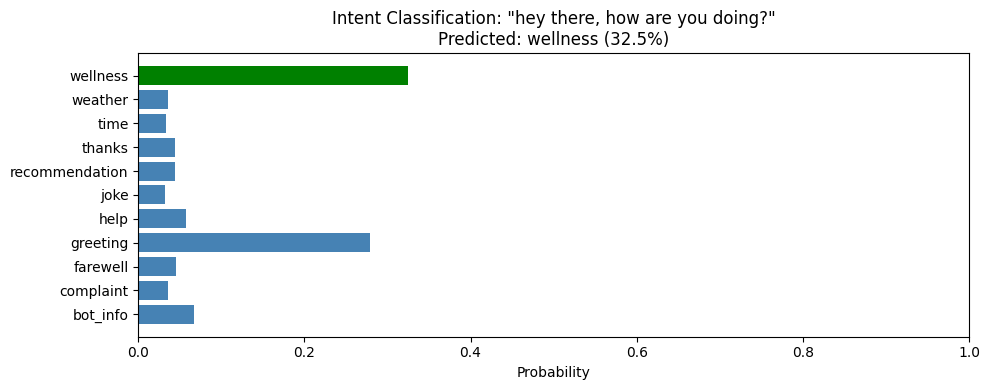

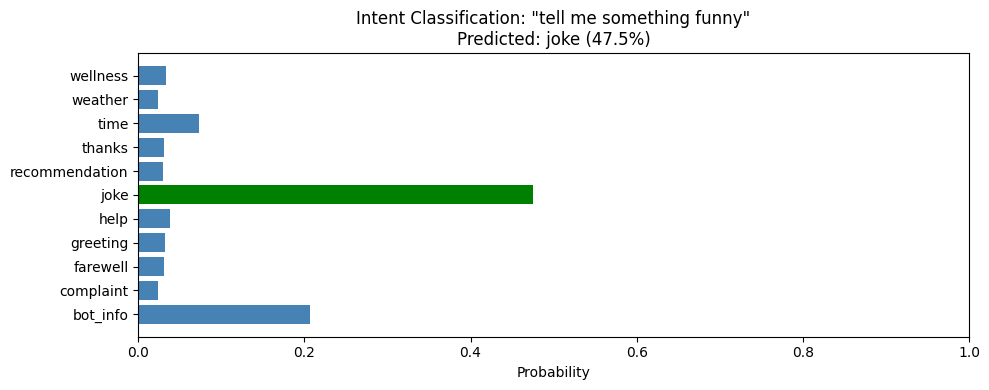

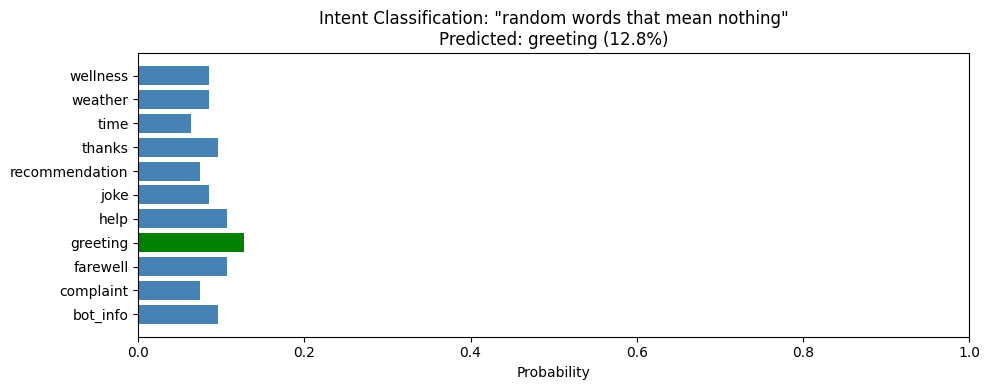

In [ ]:
import matplotlib.pyplot as plt

def visualize_intent_probabilities(bot, text):
    """Visualize probability distribution across intents"""
    intent, confidence, all_probs = bot.predict_intent(text)

    intents = list(all_probs.keys())
    probs = list(all_probs.values())

    colors = ['green' if i == intent else 'steelblue' for i in intents]

    plt.figure(figsize=(10, 4))
    plt.barh(intents, probs, color=colors)
    plt.xlabel('Probability')
    plt.title(f'Intent Classification: "{text}"\nPredicted: {intent} ({confidence:.1%})')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

# Visualize some examples
visualize_intent_probabilities(ml_bot, "hey there, how are you doing?")
visualize_intent_probabilities(ml_bot, "tell me something funny")
visualize_intent_probabilities(ml_bot, "random words that mean nothing")

---
## Comparison: All Three Methods

Let's compare how each method handles the same set of inputs.

In [ ]:
def compare_chatbots(user_input, exact_bot, pattern_bot, ml_bot):
    """Compare responses from all three chatbots"""
    print(f"Input: '{user_input}'")
    print(f"  Exact Match:    {exact_bot.get_response(user_input)}")
    print(f"  Pattern Match:  {pattern_bot.get_response(user_input)}")
    print(f"  ML Classifier:  {ml_bot.get_response(user_input)}")
    print()

print("=== Method Comparison ===")
print()

comparison_inputs = [
    "hello",                    # All should handle
    "Hey there!",               # Pattern & ML should handle
    "heya whats up",            # Only ML should handle well
    "tell me a joke",           # All should handle
    "got any jokes?",           # Pattern (fuzzy) & ML
    "make me laugh please",     # Only ML
    "10 + 5",                   # Only Pattern (math)
    "random nonsense xyz",      # None should handle confidently
]

for inp in comparison_inputs:
    compare_chatbots(inp, exact_bot, pattern_bot, ml_bot)

=== Method Comparison ===

Input: 'hello'
  Exact Match:    Hello! How can I help you today?
  Pattern Match:  Hello, Alice! Nice to see you again.
  ML Classifier:  Hey! Great to see you!

Input: 'Hey there!'
  Exact Match:    I don't understand that. Try typing 'help' for options.
  Pattern Match:  Hello, Alice! Nice to see you again.
  ML Classifier:  Hi there! What's on your mind?

Input: 'heya whats up'
  Exact Match:    I don't understand that. Try typing 'help' for options.
  Pattern Match:  I'm not sure I understand. Could you rephrase that?
  ML Classifier:  I'm not quite sure what you mean. Could you try rephrasing?

Input: 'tell me a joke'
  Exact Match:    Why don't scientists trust atoms? Because they make up everything!
  Pattern Match:  Why do programmers prefer dark mode? Because light attracts bugs!
  ML Classifier:  What's a computer's favorite snack? Microchips!

Input: 'got any jokes?'
  Exact Match:    I don't understand that. Try typing 'help' for options.
  Patte

---
## Interactive Demo

Try chatting with each bot! Run the cell below and type messages to see how they respond.

In [ ]:
# Uncomment one of these to chat interactively:
# interactive_chat(exact_bot, "ExactBot")
# interactive_chat(pattern_bot, "PatternBot")
# interactive_chat(ml_bot, "MLBot")

---
## Summary

| Aspect | Exact Matching | Pattern Matching | Machine Learning |
|--------|---------------|------------------|------------------|
| **Flexibility** | Very low | Medium | High |
| **Setup Complexity** | Simple | Moderate | Complex |
| **Handles Variations** | No | Somewhat | Yes |
| **Handles Typos** | No | Yes (fuzzy) | Somewhat |
| **Maintenance** | Manual updates | Pattern tuning | Retraining |
| **Best For** | Simple FAQs | Structured inputs | Natural conversation |

### When to Use Each

**Exact Matching** is best when you have a small, fixed set of commands and need predictable behavior (e.g., voice assistants with specific wake words).

**Pattern Matching** works well when inputs follow predictable structures but have variable components (e.g., form filling, data extraction).

**Machine Learning** excels when users express the same intent in many different ways and you want natural conversation (e.g., customer service, general assistants).

In practice, production chatbots often combine all three approaches in a hybrid architecture!

---
## Exercises

Try these to deepen your understanding:

1. **Add a new intent** to the ML chatbot (e.g., "complaints", "recommendations") with training examples
2. **Improve pattern matching** by adding regex patterns for extracting dates or email addresses
3. **Create a hybrid bot** that uses pattern matching for structured queries and ML for everything else
4. **Experiment with different classifiers** (replace Naive Bayes with SVM or Random Forest)